In [1]:
%load_ext autoreload
%autoreload 2

Hereafer I will import some of the python libraries I will use in the solution:

In [2]:
import numpy as np
import pandas as pd
import logging
import os, sys
import yaml
from sklearn.model_selection import train_test_split
import logging
from functools import partial
from forex_python.converter import CurrencyRates
import warnings
warnings.filterwarnings('ignore')

I am defining the logger, I will use it to print some information about the execution:

In [3]:
logging.basicConfig(
    stream=sys.stdout,
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%d/%m/%Y %I:%M:%S%p")

logger = logging.getLogger(__name__)

# Example: Italy's quarterly GDP forecast

In this notebook we will build a model to forecast the quarterly GDP of Italy.

In [4]:
from source.feature_extractor import FeatureExtraxtor
from source.model import MLmodel

I am loading the dataset from the web:

In [5]:
worldbank_data = pd.read_csv(os.path.join('data', 'WB_DATA_d950d0cd269a601150c0afd03b234ee2.csv'))
global_economic_indicators = pd.read_csv(os.path.join('data', 'EDIA_ECD_2_8e348bab98f433be151f325a46767c38.csv'))

In [7]:
# find the description name pattern of real gdp in usd

real_gdp_usd = global_economic_indicators[global_economic_indicators['description'].str.contains('Real GDP')]

print(real_gdp_usd)

         series_id country_code  indicator_code       identifier  \
748857       45864           AF              13  AF.SP1.013.A.01   
748858       45864           AF              13  AF.SP1.013.A.01   
748859       45864           AF              13  AF.SP1.013.A.01   
748860       45864           AF              13  AF.SP1.013.A.01   
748861       45864           AF              13  AF.SP1.013.A.01   
...            ...          ...             ...              ...   
9666424      55403           LV              45  LV.SP1.045.Q.01   
9666522      80221           LV              45  LV.SP1.045.Q.01   
9666595      80221           LV              45  LV.SP1.045.Q.01   
9666620      55403           LV              45  LV.SP1.045.Q.01   
9666722      55403           LV              45  LV.SP1.045.Q.01   

                                               description     units  \
748857   Afghanistan: Real GDP Growth (%) [Afghanistan:...  % change   
748858   Afghanistan: Real GDP Growth (

Here we extract all the quarterly GDP values for each country.

In [8]:
pattern = r'^[a-zA-Z ]+: Real GDP \(\$B\) \[.*\]$'

filtered_df = global_economic_indicators[global_economic_indicators['description'].str.match(pattern) & (global_economic_indicators['frequency'] == 'Q')]

filtered_df.loc[:, 'date'] = pd.to_datetime(filtered_df['date'])

print(filtered_df.description.unique()) 

['Albania: Real GDP ($B) [AL: Gross Domestic Product (GDP): Chain-linked 2010 Prices]'
 'Angola: Real GDP ($B) [AO: Expenditure on GDP (EG): Real: 2002 Prices (2002P): GDP at Constant Prices]'
 'Argentina: Real GDP ($B) [AR: Gross Domestic Product (GDP): 2004p: At Market Prices]'
 'Armenia: Real GDP ($B) [AM: Gross Domestic Product (GDP): Previous Year Prices (PYP)]'
 'Australia: Real GDP ($B) [Original: CVM: GDP]'
 'Austria: Real GDP ($B) [Austria: GDP Volume (spliced)]'
 'Azerbaijan: Real GDP ($B) [Azerbaijan: National accounts: Local currency constant prices: GDP (GNE+EB): QUARTERLYN]'
 'Bahrain: Real GDP ($B) [BH: Gross Domestic Product (GDP): At Purchasers Prices: 2010p]'
 'Belarus: Real GDP ($B) [BY: Gross Domestic Product (GDP): 2014p]'
 'Belgium: Real GDP ($B) [Belgium: GDP Volume (spliced)]'
 'Belize: Real GDP ($B) [BZ: Gross Domestic Product (GDP): 2000p]'
 'Bolivia: Real GDP ($B) [BO: Gross Domestic Product (GDP): 1990p]'
 'Bosnia and Herzegovina: Real GDP ($B) [Bosnia and H

From above it seems that GDP values are expressed in billions of dollars. Below we try to create a target dataset so that we have all gdp timeseries of different countries in one table, so that further analysis come handy.

In [8]:

unique_countries = filtered_df['country_code'].unique()
unique_units = filtered_df['units'].unique()

targets = {}

minimum_date = pd.Timestamp('2025-12-31')
maximum_date = pd.Timestamp('1900-01-01')

for country in unique_countries:
    country_data = filtered_df[filtered_df['country_code'] == country]

    min_date = country_data['date'].min()

    if type(min_date) == pd.Timestamp and min_date < minimum_date:
        minimum_date = min_date

    max_date = country_data['date'].max()
    if type(max_date) == pd.Timestamp and max_date > maximum_date:
        maximum_date = max_date

    country_data = country_data.sort_values(by='date')
    country_date = country_data['date']
    country_values = country_data['value']
    targets[country] = pd.Series(country_values.values, index=country_date, name=country).infer_objects()

date_range = pd.date_range(start=minimum_date, end=maximum_date, freq='QS')

# Merge all the pd.Series into the date_range dataframe
final_df = pd.DataFrame(index=date_range)
# 

for country in targets.keys():
    final_df = final_df.join(targets[country], how='left')

print(final_df)


Here we created the table of quarterly gdp for each country. However it is obvious that there is something wrong because Argentina GDP of 2020 cannot be higher than UK GDP by an order of magnitude, probably even though data says that those real gdp are in billions of dollars this may be false.

I will now try to use exchange rates from the main interesting countries to check whether a rescale to billion dollars is possible 

In [9]:

# def load_exchange_rates():
#     exchange_rates = {}
#     minimum_date = pd.Timestamp('2025-12-31')
#     maximum_date = pd.Timestamp('1900-01-01')
#     for file in os.listdir('exchange_rates'):
#         currency = file.split('_')[0]
#         if currency == 'TRL' or currency == 'BRL':
#             continue
#         currency_df = pd.read_csv(os.path.join('exchange_rates', file))
#         currency_df.index = pd.to_datetime(currency_df['Reference date (CET)'])
#         if currency_df.index.min() < minimum_date:
#             minimum_date = currency_df.index.min()
#         if currency_df.index.max() > maximum_date:
#             maximum_date = currency_df.index.max()
#         currency_df = currency_df.resample('QS').first()
#         vals = currency_df['Rate'].replace('N.A.', 'nan').astype(float).values
#         vals = np.interp(np.arange(len(vals)), np.arange(len(vals))[~np.isnan(vals)], vals[~np.isnan(vals)])
#         exchange_rates[currency] = pd.Series(vals, index = pd.to_datetime(currency_df['Reference date (CET)']), name=currency).infer_objects()


#     return exchange_rates

# exchange_rates = load_exchange_rates()

 

In [10]:
# minimum_dat = minimum_date.date()
# maximum_dat = maximum_date.date() 
# date_range = pd.date_range(start=minimum_dat, end=maximum_dat, freq='QS')

# # date_range_str = [str(i)[:10] for i in date_range]


# exchange_rates_df = pd.DataFrame(index=date_range)

# # print(exchange_rates_df)
# # print(exchange_rates['AUD'])

# for currency in exchange_rates.keys():
#     exchange_rates_df = exchange_rates_df.join(exchange_rates[currency], how='left')



# adjusted_exchange_rates = exchange_rates_df.copy()

# # adjusted_exchange_rates.loc['2002-01-01'::, 'ITL'] = adjusted_exchange_rates

In [11]:
# exchange_rates_interpolated = exchange_rates_df.interpolate()   
# exchange_rates_interpolated.plot()

It seems there are several problems with the exchange rates. We have them but it seems the conversion is hard. We will see whether world bank data is easier to handle and more consistent across states.

Below we plot the gdp for several countries it seems that we need to rescale them to achieve real comparison.

In [12]:
# import matplotlib.pyplot as plt

# interesting_countries = [
#     'AU',  # Australia
#     'BR',  # Brazil
#     'CA',  # Canada
#     'CN',  # China
#     'FR',  # France
#     'DE',  # Germany
#     'IN',  # India
#     'ID',  # Indonesia
#     'IT',  # Italy
#     'JP',  # Japan
#     'KR',  # South Korea
#     'MX',  # Mexico
#     'RU',  # Russia
#     'SA',  # Saudi Arabia
#     'ZA',  # South Africa
#     'TR',  # Turkey
#     'UK',  # United Kingdom
#     'US',  # United States
# ]

# final_copy = final_df.copy()

# g20_gdp = final_copy[['US','CN', 'RU', 'IN', 'IT', 'FR', 'KR', 'CA', 'BR', 'ES', 'UK', 'SA']]

# g20_gdp.plot()

# plt.grid()

# plt.yscale('log')

Getting the target variable:

In [13]:
target_variable = global_economic_indicators.loc[(global_economic_indicators.country_code == 'IT') & 
                                                 (global_economic_indicators.series_id == 54372)].set_index('date')['value'].shift(-1).dropna()
target_variable

date
1996-01-01    324952.1
1996-04-01    317006.3
1996-07-01    333546.7
1996-10-01    307808.1
1997-01-01    331192.8
                ...   
2018-01-01    370569.9
2018-04-01    364906.0
2018-07-01    372207.3
2018-10-01    354904.5
2019-01-01    369908.6
Name: value, Length: 93, dtype: float64

In [14]:
print(global_economic_indicators.loc[(global_economic_indicators.series_id == 54372)])


         series_id country_code  indicator_code       identifier  \
1668693      54372           IT              45  IT.SP1.045.Q.01   
1668694      54372           IT              45  IT.SP1.045.Q.01   
1668695      54372           IT              45  IT.SP1.045.Q.01   
1668696      54372           IT              45  IT.SP1.045.Q.01   
1668697      54372           IT              45  IT.SP1.045.Q.01   
...            ...          ...             ...              ...   
1668782      54372           IT              45  IT.SP1.045.Q.01   
1668783      54372           IT              45  IT.SP1.045.Q.01   
1668784      54372           IT              45  IT.SP1.045.Q.01   
1668785      54372           IT              45  IT.SP1.045.Q.01   
1668786      54372           IT              45  IT.SP1.045.Q.01   

                                               description    units frequency  \
1668693  Italy: Real GDP ($B) [IT: Gross Value Added (G...  mln EUR         Q   
1668694  Italy: Real 

Getting some features:

In [15]:
italy_all_quarterly_data = global_economic_indicators.loc[(global_economic_indicators.frequency == 'Q') & 
                                                (global_economic_indicators.country_code == 'IT')]


In [16]:
dataset = target_variable.reset_index().rename(columns={'value' : 'target_variable'})

for data in italy_all_quarterly_data.description.unique():
    print(f"Merging {data}")
    quarterly_feature =  italy_all_quarterly_data.loc[italy_all_quarterly_data.description == data][['date','value']].rename(columns={'value' : data})
    dataset = pd.merge(dataset, quarterly_feature, on='date', how='left')

Merging Italy: Private Consumption Growth (%) [IT: GDP: Final Domestic Consumption (FDC):: PCTCHG]
Merging Italy: Gross Fixed Investment Growth (%) [IT: GFCF: Total Fixed Assets by Type of Asset (TFATA): PCTCHG]
Merging Italy: Government Consumption Growth (%) [Italy: GDP: (sa): Current prices: Government final consumption: PCTCHG]
Merging Italy: Real GDP Growth (%) [IT: Gross Value Added (GVA): At Basic Prices (BP): 2010p: PCTCHG]
Merging Italy: GDP Deflator (Y=Y) [Italy: GDP Deflator]
Merging Italy: Nominal GDP ($B) [IT: Gross Value Added (GVA): At Basic Prices (BP)]
Merging Italy: Real Gross Fixed Investment ($B) [Italy: GDP: (sa): Constant prices: Gross fixed capital formation]
Merging Italy: Real GDP ($B) [IT: Gross Value Added (GVA): At Basic Prices (BP): 2010p]
Merging Italy: Industrial Production Growth (%) [IT: Industrial Production Index (IPI-15): PCTCHG: QUARTERLYN]
Merging Italy: Budget Expenditure / GDP (%) [Italy: General Govt: Operations Stmt: Expense [2]: * 100 /023_Q>>

## Model

In this section I will define and train the model.

I am defining X and y:

In [17]:
X = dataset.drop(columns='target_variable').set_index('date').fillna(-999)
y = dataset.set_index('date')['target_variable']

In [18]:
print(X.shape)

(744, 120)


I am splitting both the features and the ground truth into a train and test sample:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=False)

For this exercise, I've tested several tree-based model. I defined them in a configuration file called model_settings.yaml, now I am importing that in the code:

In [20]:
with open(os.path.join('source', 'model_settings.yaml'), 'r', encoding="utf-8") as handler:
    model_params = yaml.load(handler, Loader=yaml.FullLoader)

Now I am defining an instance of a MLmodel object, a class defined in the model.py module (in the source folder) that contain several useful methods for dealing with tree based classification models.
I've choosen this class of models because they offer a great compromise between simplicity and quality of the predictios.

In [21]:
regressor = MLmodel(model_params['RandomForest'])

Now I am launching the optimization routine based on gridsearch or randomsearch (to be chosen in the configuration file). 

In [22]:
# TODO -> The optimization routine must be fixed
# regressor.optimize(X_train, y_train)

Finally, I am fitting the model:

In [23]:
regressor.fit(X_train, y_train)

## Feature Importance

Now I am assembling the predictions:

In [24]:
results_train = y_train.reset_index()
results_test = y_test.reset_index()
results_train['Prediction'] = regressor.predict(X_train)
results_test['Prediction'] = regressor.predict(X_test)

In the cell below, I'll print some quality metrics, to check the quality of the model:

In [25]:
#TODO 

Let's plot the features importances. Tree based models offer a simple method to check the relative importances of the features, so I think they are a great choice to easily get some extra-insight about the goodness of the chosen features. In this case, I made several attempts and I deleted some features which importance were always 0 or close to 0. There are also automatic routines defined in scikit-learn to do this task (for example sklearn.feature_selection.RFE) but they require a lot of time to run.

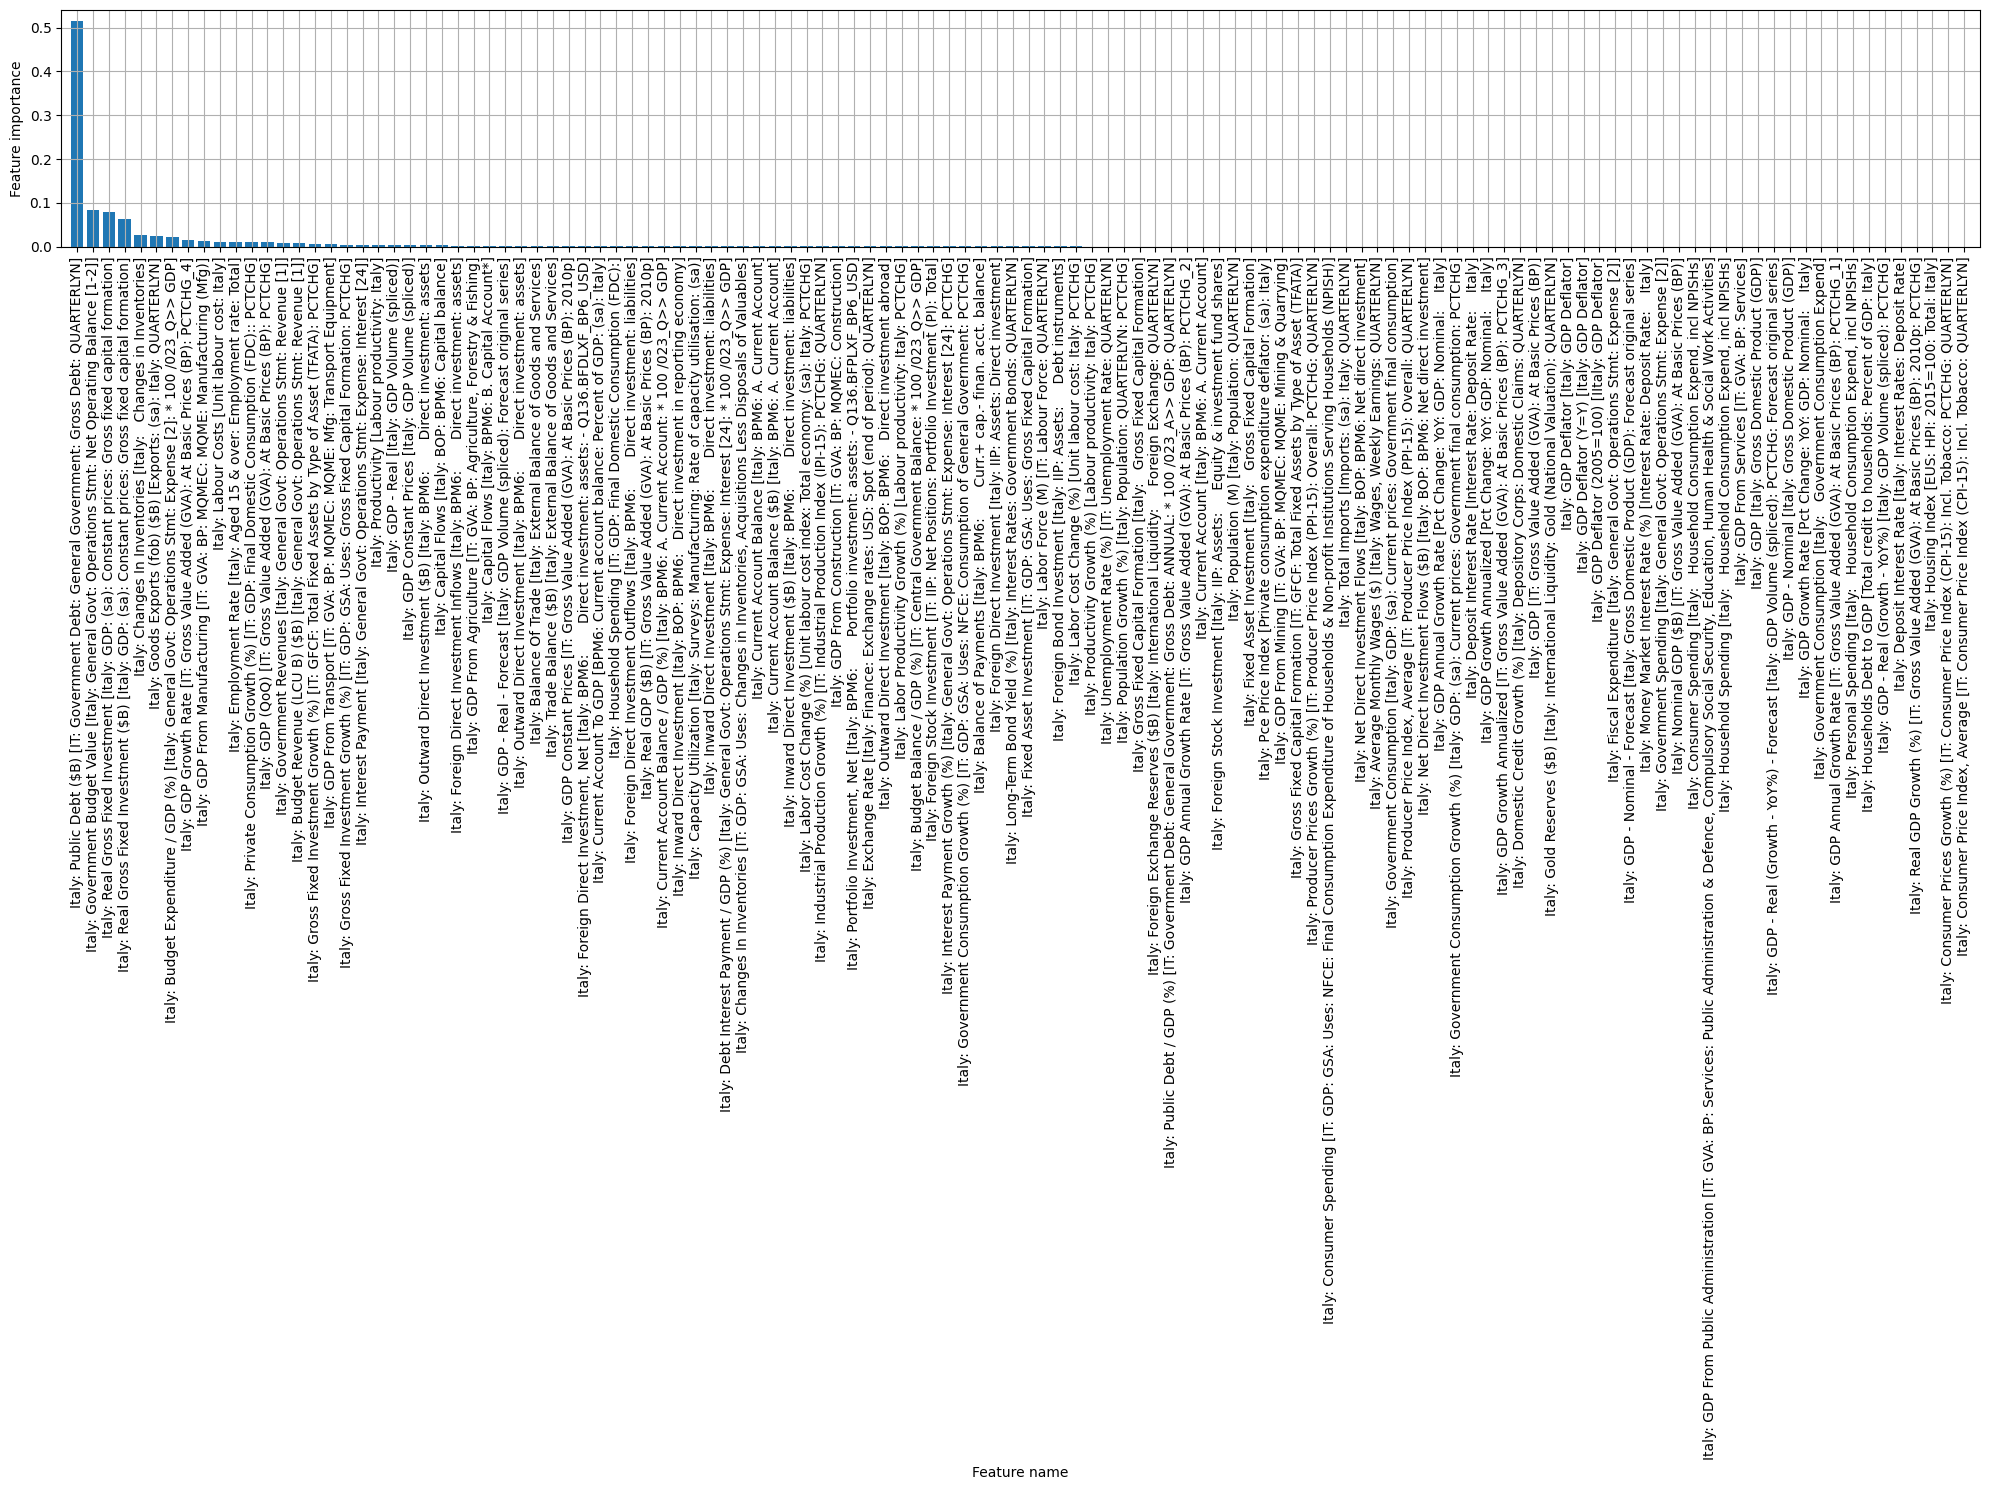

31/05/2024 07:03:07PM - INFO - 
--------- Feature Importance ---------
31/05/2024 07:03:07PM - INFO -  1) Italy: Public Debt ($B) [IT: Government Debt: General Government: Gross Debt: QUARTERLYN] 0.514401
31/05/2024 07:03:07PM - INFO -  2) Italy: Government Budget Value [Italy: General Govt: Operations Stmt: Net Operating Balance [1-2]] 0.083042
31/05/2024 07:03:07PM - INFO -  3) Italy: Real Gross Fixed Investment [Italy: GDP: (sa): Constant prices: Gross fixed capital formation] 0.080179
31/05/2024 07:03:07PM - INFO -  4) Italy: Real Gross Fixed Investment ($B) [Italy: GDP: (sa): Constant prices: Gross fixed capital formation] 0.064048
31/05/2024 07:03:07PM - INFO -  5) Italy: Changes In Inventories [Italy:   Changes in Inventories] 0.026094
31/05/2024 07:03:07PM - INFO -  6) Italy: Goods Exports (fob) ($B) [Exports: (sa): Italy: QUARTERLYN] 0.025157
31/05/2024 07:03:07PM - INFO -  7) Italy: Budget Expenditure / GDP (%) [Italy: General Govt: Operations Stmt: Expense [2]: * 100 /023_Q>

In [26]:
regressor.plot_features_importances(X.columns)

# PredictionPlot

In [27]:
full_hist = pd.concat([results_train, results_test])
full_hist

,date,target_variable,Prediction
0,1996-01-01,324952.1,324952.100
1,1996-01-01,324952.1,324952.100
2,1996-01-01,324952.1,324952.100
3,1996-01-01,324952.1,324952.100
4,1996-01-01,324952.1,324952.100
...,...,...,...
144,2019-01-01,369908.6,363450.024
145,2019-01-01,369908.6,363450.024
146,2019-01-01,369908.6,363450.024
147,2019-01-01,369908.6,363450.024


In [28]:
import plotly.express as px
fig = px.line(full_hist, x='date', y=['Prediction', 'target_variable'], markers=True)
fig.show()